<a href="https://colab.research.google.com/github/kratiagrawal100/SMAI_Team_30/blob/main/unsupervised_domain_adaptation_MNIST_SVHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

In [40]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),    # resize the images to 28x28
    transforms.ToTensor()           # convert the images to PyTorch tensors
])
train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [43]:
len(train_dataset)

73257

In [44]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)


torch.Size([3, 28, 28])


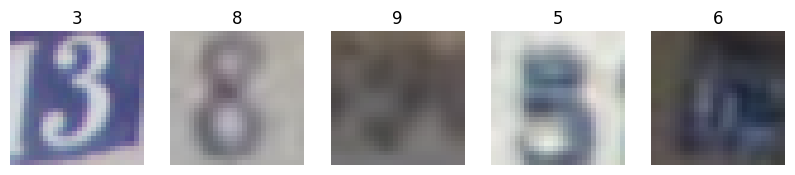

In [45]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
print(images[0].shape)
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')
  img = images[i].permute(1, 2, 0)
  plt.imshow(img)
  plt.title(labels[i].numpy())

In [28]:
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255
mean = mnist_pixels.mean().item()
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])
transform = transforms.Compose([
  transforms.ToTensor(),
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
  transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

100%|██████████| 9912422/9912422 [00:00<00:00, 94814777.95it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19112605.53it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26966850.05it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12941935.30it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Mean 0.13066047430038452 and Std 0.30810782313346863


torch.Size([3, 28, 28])


<Figure size 1000x1000 with 0 Axes>

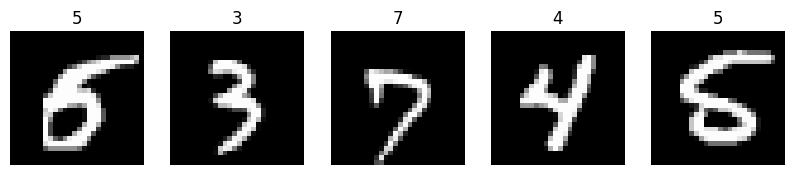

In [37]:
dataiter = iter(source_train_loader)
images, labels = next(dataiter)
print(images[0].shape)
plt.figure(figsize=(10, 10))

plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x = images[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(labels[i].numpy())

In [ ]:
class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=5),  # 64x24x24
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),  # 32x12x12
        nn.Conv2d(32, 48, kernel_size=5),  # 48x8x8
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),  # 48x4x4
    )

    self.classif = nn.Sequential(
        nn.Linear(4 * 4 * 48, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    batch_size = len(x)

    x = self.cnn(x)
    x = x.view(batch_size, -1)
    return self.classif(x)
